In [14]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from Utils import *

# Load the data
training_data = np.load('training_data.npy')
valid_periods = np.load('valid_periods.npy')
categories = np.load('categories.npy')

In [4]:
dataset, labels = build_sequences_optimized(training_data, valid_periods)

Dataset shape:  (48000, 200)


In [5]:
train_data, train_labels, test_data, test_labels = split_dataset(dataset, labels)

Train data shape:  (38400, 200)
Test data shape:  (9600, 200)


In [6]:
# Train a forecasting model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_data, train_labels)

# Make predictions on the test data
predictions = model.predict(test_data)

MAE: 0.11333084585729576
MSE: 0.025716736011604804
RMSE: 0.16036438510967704
MAPE: 29.547357309902306%


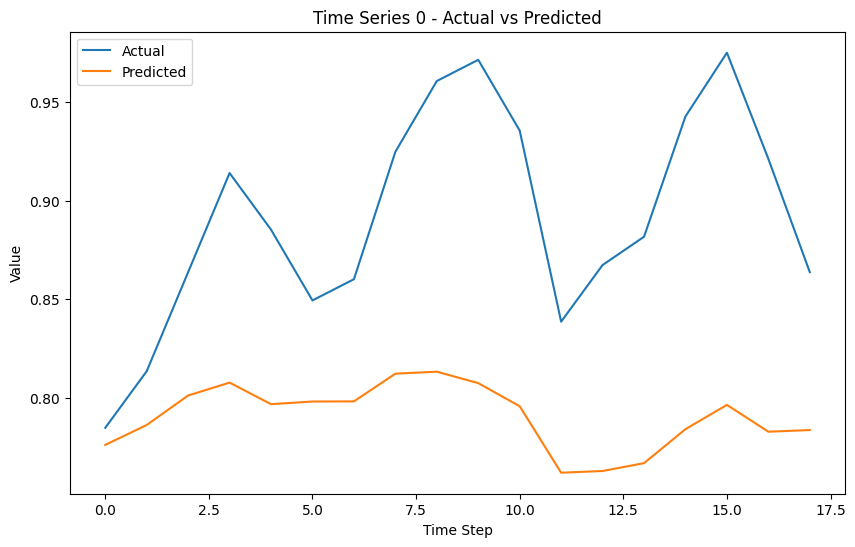

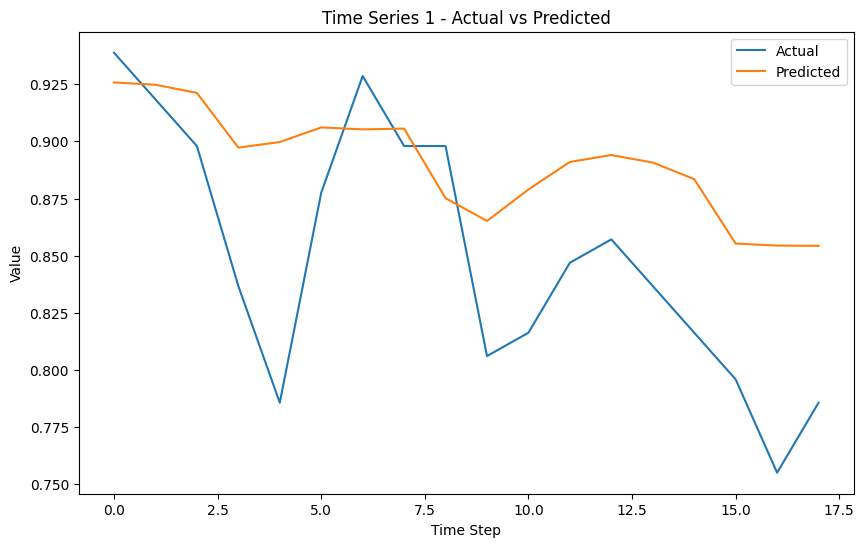

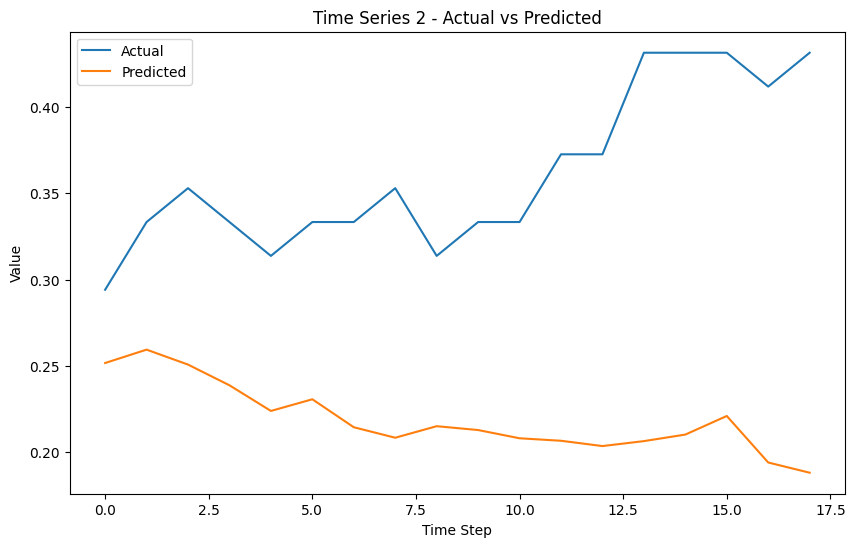

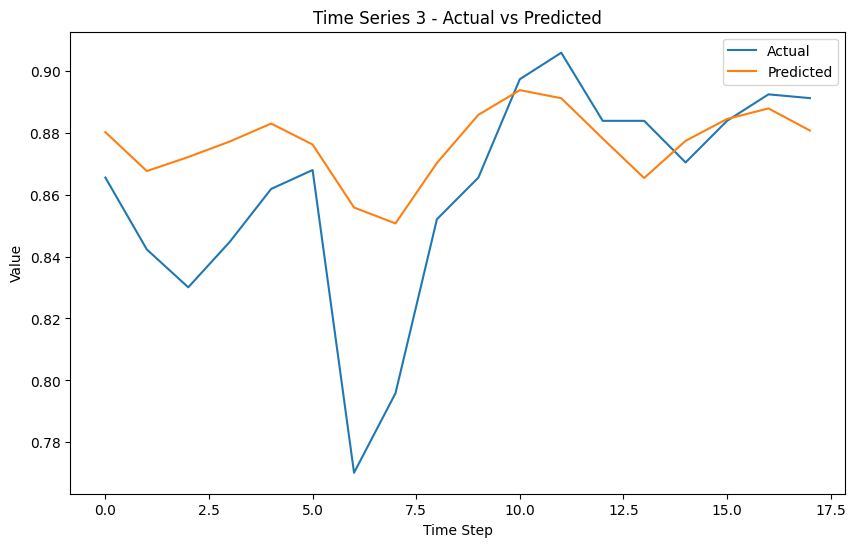

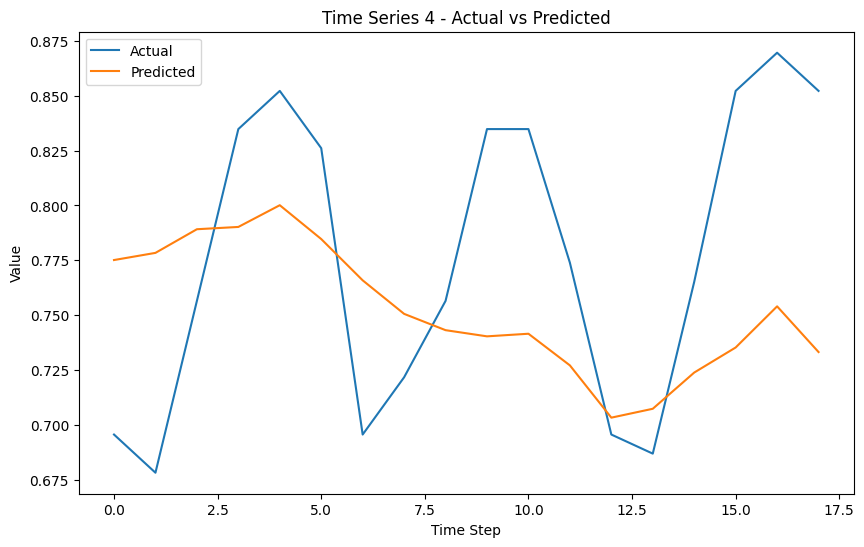

In [23]:
evaluate_model(predictions, test_labels)
for i in range(5):
    # Plot the first 5 predictions
    plot_predictions(predictions, test_labels, i)

In [ ]:
keras